In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pathlib

p = pathlib.Path('.')



In [4]:
import pandas as pd

list((p/'large_files').iterdir())

[PosixPath('large_files/img64'),
 PosixPath('large_files/extract_even.sh'),
 PosixPath('large_files/images_01.tar.gz'),
 PosixPath('large_files/Data_Entry_2017.csv'),
 PosixPath('large_files/images_05.tar.gz'),
 PosixPath('large_files/images_12.tar.gz'),
 PosixPath('large_files/test_list.txt'),
 PosixPath('large_files/images_04.tar.gz'),
 PosixPath('large_files/images_07.tar.gz'),
 PosixPath('large_files/train_val_list.txt'),
 PosixPath('large_files/images_09.tar.gz'),
 PosixPath('large_files/BBox_List_2017.csv'),
 PosixPath('large_files/images'),
 PosixPath('large_files/extract_odd2.sh'),
 PosixPath('large_files/.ipynb_checkpoints'),
 PosixPath('large_files/images_11.tar.gz'),
 PosixPath('large_files/images_08.tar.gz'),
 PosixPath('large_files/xaa'),
 PosixPath('large_files/img128'),
 PosixPath('large_files/images_03.tar.gz'),
 PosixPath('large_files/images_10.tar.gz'),
 PosixPath('large_files/images_06.tar.gz'),
 PosixPath('large_files/img256'),
 PosixPath('large_files/images_02.tar.

In [6]:
de = pd.read_csv(p/'large_files'/'Data_Entry_2017.csv')

training = [line.rstrip() for line in open(p/'large_files'/'train_val_list.txt')]
testing  = [line.rstrip() for line in open(p/'large_files'/'test_list.txt')]

In [23]:
de.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
4999,00001336_000.png,No Finding,0,1336,16,M,PA,2048,2500,0.171,0.171,NaN
5000,00001337_000.png,No Finding,0,1337,53,F,PA,2992,2991,0.143,0.143,NaN
5001,00001338_000.png,No Finding,0,1338,60,M,PA,2992,2991,0.143,0.143,NaN
5002,00001338_001.png,No Finding,1,1338,61,M,AP,3056,2544,0.139,0.139,NaN
5003,00001338_002.png,Infiltration,2,1338,61,M,AP,3056,2544,0.139,0.139,NaN


In [9]:
de.shape

(112120, 12)

In [10]:
all_images = [str(i).split('/')[-1] for i in list((p/'large_files'/'images').iterdir())]
print(all_images[:3])

de = de[de['Image Index'].isin(all_images)]

['00019921_000.png', '00026925_010.png', '00017318_019.png']


In [11]:
de.shape

(107121, 12)

In [12]:
train_df = de[de['Image Index'].isin(training)]
print(train_df.shape)
test_df  = de[de['Image Index'].isin(testing) ]
print(test_df.shape)

(82492, 12)
(24629, 12)


In [13]:
from fastai.vision import *

In [15]:
[x for x in dir() if 'tem' in x]

['FloatItem',
 'ImageItemList',
 'ItemBase',
 'ItemList',
 'ItemLists',
 'ItemsList',
 'ListOrItem',
 'ObjectItemList',
 'OptListOrItem',
 'PointsItemList',
 'SegmentationItemList',
 'itemgetter']

In [16]:
src = ImageItemList.from_df??

In [41]:
src = (ImageItemList.from_df(df=train_df, cols='Image Index', path=p/'large_files'/'img256')
      .random_split_by_pct(seed=777).label_from_df(cols='Finding Labels', label_delim ='|'))
data256 = src.databunch().normalize(imagenet_stats)

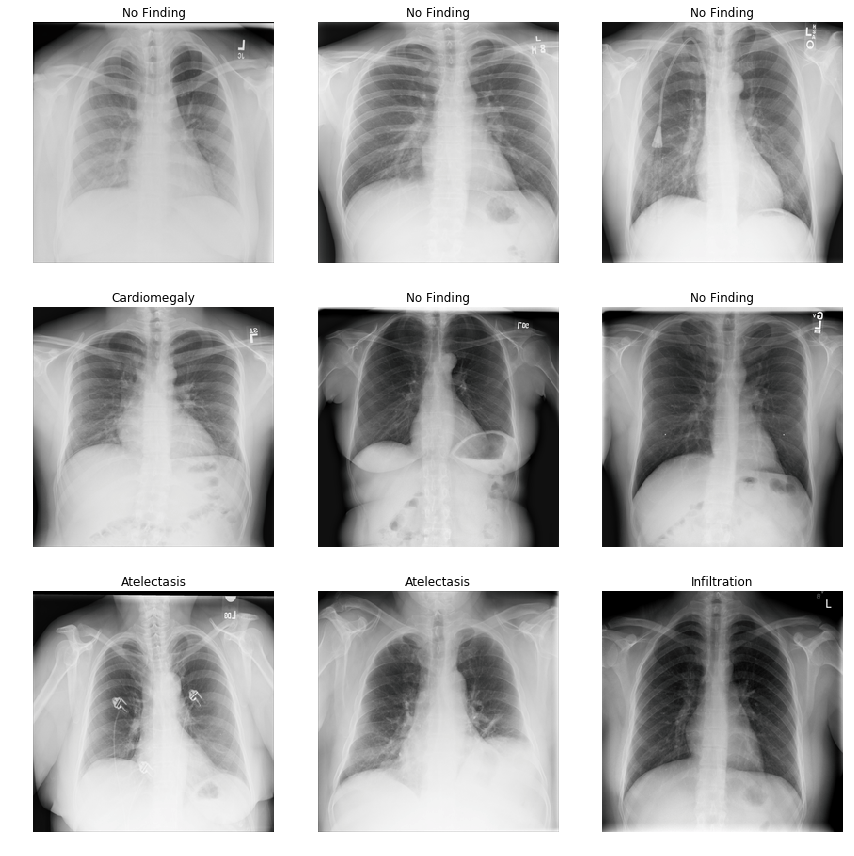

In [61]:
data256.show_batch(rows=3)

In [43]:
learn = create_cnn(data=data256, arch=models.resnet34,  metrics=[accuracy_thresh, fbeta])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


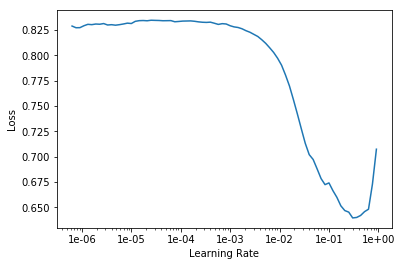

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(4, slice(1e-1/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.183924,0.182600,0.936788,0.641275
2,0.182870,0.223154,0.936756,0.646271
3,0.171858,0.176596,0.937976,0.653691
4,0.163392,0.172674,0.938643,0.656642


In [46]:
learn.save('B-256-F')

In [47]:
learn.unfreeze()

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


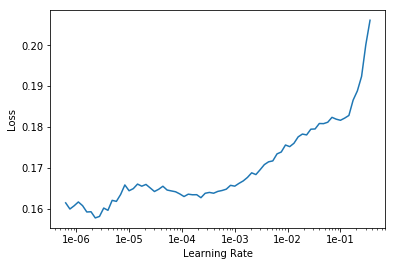

In [49]:
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(4, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.169740,0.184093,0.937782,0.654187
2,0.163583,0.170762,0.939290,0.665842
3,0.153942,0.163566,0.939807,0.675287
4,0.139617,0.165822,0.939423,0.671815


In [51]:
learn.save('B-256-U')

In [55]:
te_src = (ImageItemList.from_df(df=test_df, cols='Image Index', path=p/'large_files'/'img256')
         .no_split().label_from_df(cols='Finding Labels', label_delim='|'))
test_data = te_src.databunch().normalize(imagenet_stats)

In [57]:
learn.load('B-256-U')
learn.data = test_data

preds,y,losses = learn.get_preds(ds_type=DatasetType.Train, with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)



AttributeError: 'Learner' object has no attribute 'c'

# Test Eval

In [60]:
from sklearn.metrics import roc_auc_score

for c in range(test_data.c):
    auc_score = roc_auc_score(y[:, c], preds[:, c])
    print(f'{test_data.classes[c]} : ', auc_score)

Atelectasis :  0.7544743022641465
Cardiomegaly :  0.8692557203327528
Consolidation :  0.727990076707849
Edema :  0.8264731017678681
Effusion :  0.8127839509400122
Emphysema :  0.8967536963291837
Fibrosis :  0.7894568095316896
Hernia :  0.831206048779927
Infiltration :  0.689773735023187
Mass :  0.7871160418865754
No Finding :  0.7201584425654355
Nodule :  0.7239466882634974
Pleural_Thickening :  0.7507962198641226
Pneumonia :  0.7170108541210944
Pneumothorax :  0.844776763743874
